Bureau of Labor Statistics API with Python
======

## Unemployment rates by race/origin 

------

*September 3, 2017*<br>
*@bd_econ*

BLS API documentation is [here](https://www.bls.gov/developers/)

This example collects data on the unemployment rate for White, Black, and Hispanic populations in the US and plots the results.

In [1]:
%matplotlib inline
import pandas as pd
import requests
import json

api_url = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

# API key in config.py which contains: bls_key = 'key'
import config
key = '?registrationkey={}'.format(config.bls_key)

## Parameters/ Date handling

The BLS API limits how many years of data can be returned in a request. The small while loop below splits a date range into chunks that the BLS API will accept.

In [2]:
# Series stored as a dictionary
series_dict = {
    'LNS14000003': 'White', 
    'LNS14000006': 'Black', 
    'LNS14000009': 'Hispanic'}

# Start year and end year
date_r = (1975, 2018)

# Handle dates
dates = [(str(date_r[0]), str(date_r[1]))]
while int(dates[-1][1]) - int(dates[-1][0]) > 10:
    dates = [(str(date_r[0]), str(date_r[0]+9))]
    d1 = int(dates[-1][0])
    while int(dates[-1][1]) < date_r[1]:
        d1 = d1 + 10
        d2 = min([date_r[1], d1+9])
        dates.append((str(d1),(d2))) 

## Get the data

In [3]:
df = pd.DataFrame()

for start, end in dates:
    # Submit the list of series as data
    data = json.dumps({
        "seriesid": list(series_dict.keys()),
        "startyear": start, "endyear": end})

    # Post request for the data
    p = requests.post(
        '{}{}'.format(api_url, key), 
        headers={'Content-type': 'application/json'}, 
        data=data).json()
    for s in p['Results']['series']:
        col = series_dict[s['seriesID']]
        for r in s['data']:
            date = pd.to_datetime('{} {}'.format(
                r['periodName'], r['year']))
            df.at[date, col] = float(r['value'])
df = df.sort_index()
# Output results
print('Post Request Status: {}'.format(p['status']))
df.tail(13)

Post Request Status: REQUEST_SUCCEEDED


,White,Black,Hispanic
2017-12-01,3.7,6.7,4.9
2018-01-01,3.5,7.7,5.0
2018-02-01,3.7,6.8,4.9
2018-03-01,3.6,6.8,5.1
2018-04-01,3.5,6.5,4.8
2018-05-01,3.5,5.9,4.9
2018-06-01,3.5,6.5,4.6
2018-07-01,3.3,6.6,4.5
2018-08-01,3.4,6.3,4.7
2018-09-01,3.3,6.0,4.5


## Plot the results

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
mpl.rc('axes', edgecolor='white') # Hide the axes
plt.rc('axes', axisbelow=True)

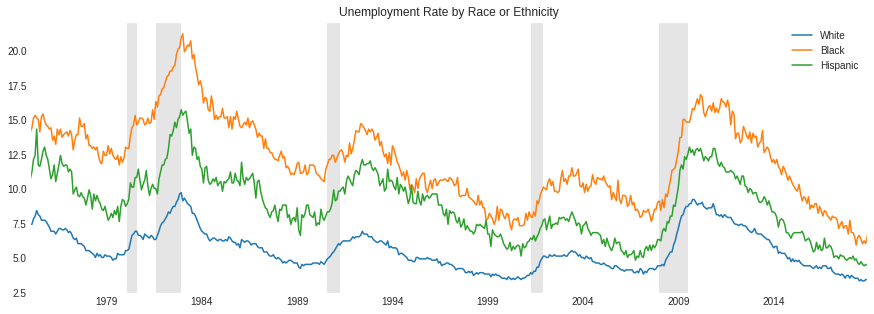

In [5]:
df.dropna().plot(title='Unemployment Rate by Race or Ethnicity', figsize=(15, 5))

# Shaded bars indicating recessions
for i, v in pd.read_csv('rec_dates.csv').dropna().loc[2:].iterrows():
    plt.axvspan(v['peak'], v['trough'], fill=True, 
                linewidth=0, color='gray', alpha=0.2)  